## Quadrature

This is a notebook that illustrates differences in the quadrature methods which are central to the evaluation of

$$
\int_0^{\pi} f(\theta) \sin \theta \; \mathrm{d}\theta = \int_{-1}^{1} f(\cos \theta) \; \mathrm{d}\cos \theta.
$$

Quadrature is used to compute the projection onto the associated Legendre functions in `torch-harmonics`.

In order to illustrate how interpolation and quadrature affect the error in the computation of the SHT, this notebook contains example for both errors.

In [1]:
import numpy as np
import paddle
import scipy
import matplotlib.pyplot as plt

c:\Users\lixia\AppData\Local\anaconda3\envs\paddle310\lib\site-packages\paddle\utils\cpp_extension\extension_utils.py:686: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


In [2]:
n_theta = 80

In [3]:
import sys
sys.path.append("..")
from paddle_harmonics.quadrature import *

### Test interpolation

we first assess the interpolation onto the quadrature nodes:

In [4]:
# interpolation - careful - this breaks if points align (for non-periodic signals)
def interpolate(t, tq, f):
    j = np.searchsorted(t, tq) - 1
    d = paddle.to_tensor((tq - t[j]) / np.diff(t)[j])
    j = paddle.to_tensor(j)
    interp = paddle.lerp(paddle.to_tensor(f[j]), paddle.to_tensor(f[j + 1]), d)
    # interp = f[j] + (f[j+1] - f[j]) * (tq - t[j]) / np.diff(t)[j]
    # print(d)
    # print(f[j+1] - f[j])
    # print(j)
    return interp

In [5]:
cost_lg, wlg = legendre_gauss_weights(n_theta, -1, 1)
# cost_lg, wlg = lobatto_weights(n_theta, -1, 1)
tq = np.flip(np.arccos(cost_lg))
teq = np.linspace(0, np.pi, n_theta, dtype=np.float64)

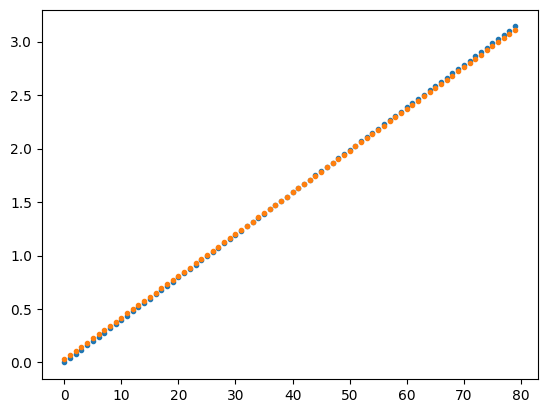

In [6]:
plt.plot(teq, '.')
plt.plot(tq, '.')
plt.show()

test interpolation:

In [7]:
f = lambda t : np.cos(4*t)
# f = lambda t : 1 / (1 + 25 * (2*(t-np.pi/2)/np.pi)**2)
# f = lambda t : 1 / (1 + 25 * np.cos(t)**2)
# f = lambda t : t**5 - 3*t**2 - 2*t + 1.0

interp = interpolate(teq, tq, f(teq))

In [8]:
interp

Tensor(shape=[80], dtype=float64, place=Place(gpu:0), stop_gradient=True,
       [0.99051621, 0.96017247, 0.90654557, 0.83090023, 0.73507102, 0.62138695,
        0.49261122, 0.35187340, 0.20259315, 0.04839723, -0.10696858, -0.25973031,
        -0.40617737, -0.54275253, -0.66613820, -0.77333689, -0.86174389, -0.92921053,
        -0.97409622, -0.99530837, -0.99232890, -0.96522689, -0.91465698, -0.84184357,
        -0.74855128, -0.63704220, -0.51002113, -0.37057012, -0.22207379, -0.06813728,
        0.08750110, 0.24106052, 0.38880936, 0.52715572, 0.65273465, 0.76248985,
        0.85374796, 0.92428359, 0.97237355, 0.99683884, 0.99683884, 0.97237355,
        0.92428359, 0.85374796, 0.76248985, 0.65273465, 0.52715572, 0.38880936,
        0.24106052, 0.08750110, -0.06813728, -0.22207379, -0.37057012, -0.51002113,
        -0.63704220, -0.74855128, -0.84184357, -0.91465698, -0.96522689, -0.99232890,
        -0.99530837, -0.97409622, -0.92921053, -0.86174389, -0.77333689, -0.66613820,
        -0

In [9]:
f(teq)

array([ 1.        ,  0.98737534,  0.94982013,  0.88828261,  0.80431657,
        0.70004207,  0.578092  ,  0.4415455 ,  0.29385027,  0.13873553,
       -0.01988219, -0.1779979 , -0.33161928, -0.4768675 , -0.61007515,
       -0.72787881, -0.82730403, -0.90584039, -0.9615049 , -0.99289207,
       -0.9992094 , -0.98029737, -0.9366335 , -0.86932027, -0.78005731,
       -0.67109843, -0.54519477, -0.40552532, -0.25561663, -0.0992538 ,
        0.05961513,  0.21697881,  0.36886392,  0.51143548,  0.64109364,
        0.75456462,  0.84898336,  0.92196585,  0.97166934,  0.99683884,
        0.99683884,  0.97166934,  0.92196585,  0.84898336,  0.75456462,
        0.64109364,  0.51143548,  0.36886392,  0.21697881,  0.05961513,
       -0.0992538 , -0.25561663, -0.40552532, -0.54519477, -0.67109843,
       -0.78005731, -0.86932027, -0.9366335 , -0.98029737, -0.9992094 ,
       -0.99289207, -0.9615049 , -0.90584039, -0.82730403, -0.72787881,
       -0.61007515, -0.4768675 , -0.33161928, -0.1779979 , -0.01

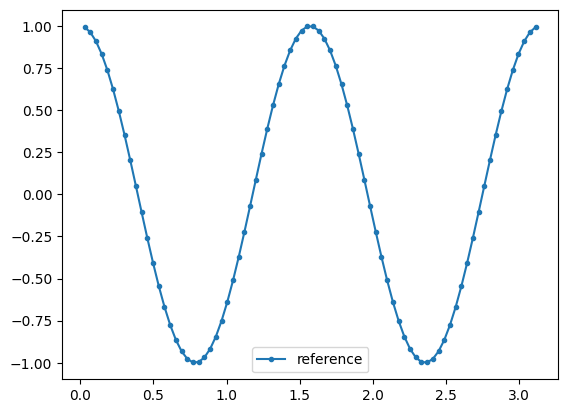

In [10]:
# plt.plot(teq, f(teq), '.-', label="reference")
plt.plot(tq, f(tq), '.-', label="reference")
# plt.plot(tq, interp, '.-', label="interpolated")
plt.legend()
plt.show()

### Test quadrature with associated Legendre polynomials

let us test different quadrature modes:

In [11]:
def precompute_legpoly(m_max, l_max, x):
    """
    Computes the values of P^m_n(\cos \theta) at the positions specified by x (theta)
    The resulting tensor has shape (m_max, l_max, len(x))
    """

    # compute the tensor P^m_n:
    pct = np.zeros((m_max, l_max, len(x)), dtype=np.float64)

    sinx = np.sin(x)
    cosx = np.cos(x)

    a = lambda m, l: np.sqrt((4*l**2 - 1) / (l**2 - m**2))
    b = lambda m, l: -1 * np.sqrt((2*l+1)/(2*l-3)) * np.sqrt(((l-1)**2 - m**2)/(l**2 - m**2))

    # start by populating the diagonal and the second higher diagonal
    amm = np.sqrt( 1. / (4 * np.pi) )
    pct[0,0,:] = amm
    pct[0,1,:] = a(0, 1) * cosx * amm
    for m in range(1, min(m_max, l_max)):
        pct[m,m,:] = -1*np.sqrt( (2*m+1) / (2*m) ) * pct[m-1,m-1,:] * sinx
        if m + 1 < l_max:
            pct[m,m+1,:] = a(m, m+1) * cosx * pct[m,m,:]

    # fill the remaining values on the upper triangle
    for m in range(0, m_max):
        for l in range(m+2, l_max):
            pct[m,l,:] = a(m,l) * cosx * pct[m,l-1,:] + b(m,l) * pct[m,l-2,:]

    return paddle.to_tensor(pct)

Let us plot the Legendre polynomials:

C:\Users\lixia\AppData\Local\Temp\ipykernel_27764\3670297094.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


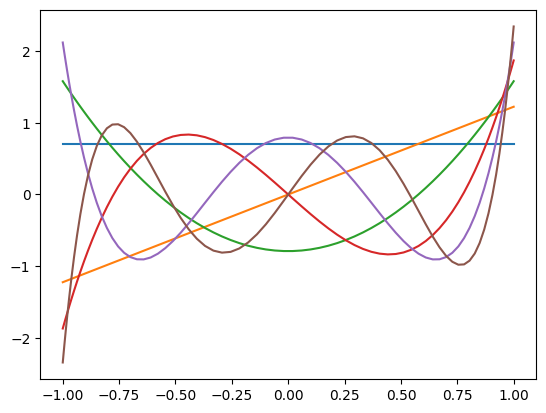

In [12]:
m = 0

pct = np.sqrt(2 * np.pi) * precompute_legpoly(n_theta, n_theta, teq)

fig, ax = plt.subplots(1, 1)
for l in range(6):
    ax.plot(np.cos(teq), pct.numpy()[0, l])
fig.show()

In [13]:
def project(t, w, f, mmax=None):
    m = 0
    if mmax == None:
        mmax = len(t)

    weights = paddle.to_tensor(w)
    pct = np.sqrt(2 * np.pi) * precompute_legpoly(mmax, mmax, t)
    weights = paddle.einsum('mlk,k->mlk', pct, weights)

    proj = paddle.einsum('...k,lk->...l', paddle.to_tensor(f), weights[m])
    rec = paddle.einsum('...l, lk->...k', proj, pct[m] )
    return rec

let us compare the accuracy of the different projection methods:

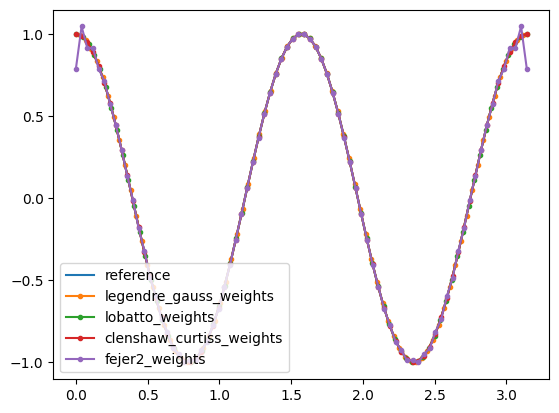

In [14]:
t = np.linspace(0, np.pi, n_theta)
plt.plot(t, f(t), label="reference")

for quadrature in [legendre_gauss_weights, lobatto_weights, clenshaw_curtiss_weights, fejer2_weights]:
    cost, wq = quadrature(n_theta, -1, 1)
    tq = np.flip(np.arccos(cost))

    out = project(tq, wq, f(tq))

    plt.plot(tq, out.numpy(), '.-', label=quadrature.__name__)

plt.legend(loc='lower left')
plt.show()

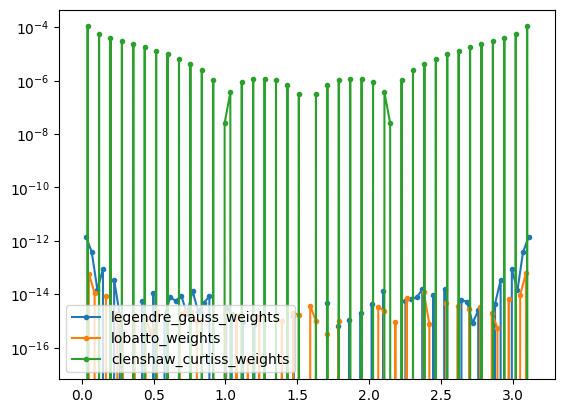

In [15]:
for quadrature in [legendre_gauss_weights, lobatto_weights, clenshaw_curtiss_weights]:
    cost, wq = quadrature(n_theta, -1, 1)
    tq = np.flip(np.arccos(cost))

    out = project(tq, wq, f(tq))
    # print(np.abs(out - f(tq)))

    plt.semilogy(tq, out.numpy() - f(tq), '.-', label=quadrature.__name__)

plt.legend(loc='lower left')
plt.show()

Let us now add interpolation into the mix to evaluate performance with interpolation taken into account. For this particular case, we will assume that the data is given to us on an equidistant grid.

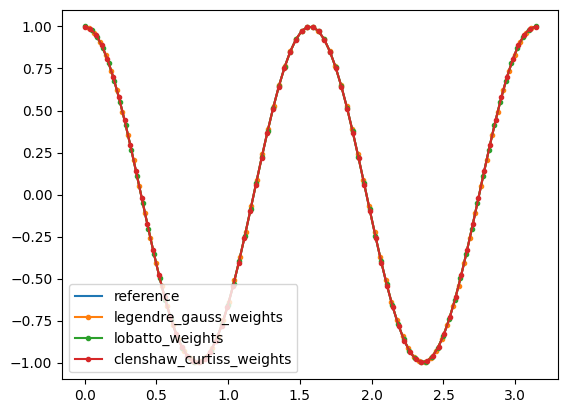

In [16]:
t = np.linspace(0, np.pi, n_theta)
ref = f(t)
plt.plot(t, ref, label="reference")

for quadrature in [legendre_gauss_weights, lobatto_weights, clenshaw_curtiss_weights]:
    cost, wq = quadrature(n_theta, -1, 1)
    tq = np.flip(np.arccos(cost))

    if quadrature == lobatto_weights or quadrature == legendre_gauss_weights:
        f_interp = interpolate(t, tq, ref)
        mmax = len(tq)
    else:
        f_interp = ref
        mmax = len(tq)

    out = project(tq, wq, f_interp, mmax=mmax)

    plt.plot(tq, out.numpy(), '.-', label=quadrature.__name__)

plt.legend(loc='lower left')
plt.show()

again, let us plot the overall error, this time including the interpolation error:

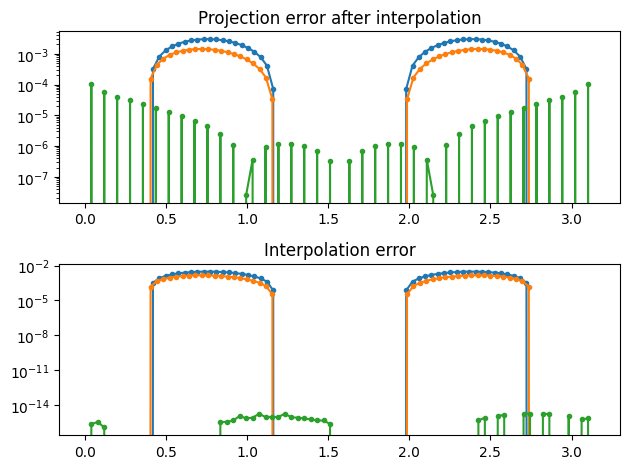

In [17]:
t = np.linspace(0, np.pi, n_theta)
ref = f(t)

fig, ax = plt.subplots(2, 1)

for quadrature in [legendre_gauss_weights, lobatto_weights, clenshaw_curtiss_weights]:
    cost, wq = quadrature(n_theta, -1, 1)
    tq = np.flip(np.arccos(cost))

    if quadrature == lobatto_weights or quadrature == legendre_gauss_weights:
        f_interp = interpolate(t, tq, ref).numpy()
        mmax = len(tq)
    else:
        f_interp = ref
        mmax = len(tq)

    out = project(tq, wq, f_interp, mmax=mmax)

    ax[0].semilogy(tq, out.numpy() - f(tq), '.-', label=quadrature.__name__)
    ax[1].semilogy(tq, f_interp - f(tq), '.-', label=quadrature.__name__)

ax[0].set_title("Projection error after interpolation")
ax[1].set_title("Interpolation error")
# ax[0].legend(loc='lower left')
# ax[1].legend(loc='lower left')
fig.tight_layout()
plt.show()

we can see that the interpolation dominates when we interpolate the solution. For this reason, it is reasonable t choose Clenshaw-Curtiss quadrature in scenarios where we expect the interpolation error to dominate.